Env Variables

In [1]:
# !pip install pandas numpy tensorflow matplotlib imageio scikit-image

In [2]:
SOURCE_FOLDER = './Source/'
T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'

batch_size = 10 
img_height = 120
img_width = 120

Import Libraries

In [ ]:
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import imread 
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import plot_model

2025-04-30 14:37:35.060976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746004055.079454  277604 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746004055.085023  277604 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746004055.099666  277604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746004055.099691  277604 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746004055.099694  277604 computation_placer.cc:177] computation placer alr

Data Loading

In [4]:
t1_images = glob.glob(T1_FOLDER+'*.png')
t2_images = glob.glob(T2_FOLDER+'*.png')

In [5]:
t1_df = pd.DataFrame({'t1_images': t1_images, 'label': 't1'})
t2_df = pd.DataFrame({'t2_images': t2_images, 'label': 't2'})

Img to Pixel conversion

In [6]:
img_lst = []
for idx, img in enumerate(t1_df['t1_images']):
    pxl = imread(img)
    img_lst.append(pxl)

t1_df['img_pxl'] = img_lst

img_lst = []
for idx, img in enumerate(t2_df['t2_images']):
    pxl = imread(img)
    img_lst.append(pxl)

t2_df['img_pxl'] = img_lst

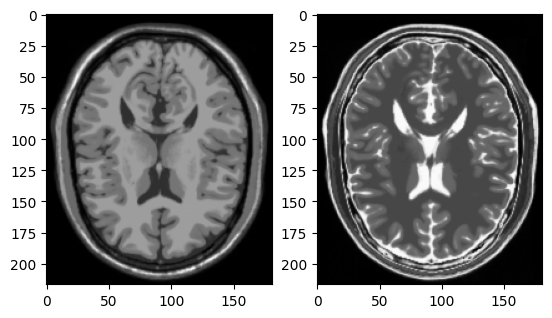

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(t1_df['img_pxl'][0], cmap='grey')
axs[1].imshow(t2_df['img_pxl'][0], cmap='grey')
plt.show();

Image Resizing

In [8]:
t1_images = np.zeros((t1_df.shape[0], img_height, img_width))
t2_images = np.zeros((t2_df.shape[0], img_height, img_width))

for idx, img in enumerate(t1_df['img_pxl']):
    t1_images[idx, :, :] = resize(img, (img_height, img_width))
    
for idx, img in enumerate(t2_df['img_pxl']):
    t2_images[idx, :, :] = resize(img, (img_height, img_width))

t1_images.shape    
t2_images.shape

(43, 120, 120)

(46, 120, 120)

Image Reshaping, Shuffling and Batch Processing

In [9]:
t1_images = t1_images.reshape(t1_images.shape[0], img_height, img_width, 1).astype('float32')
t1_images = t2_images.reshape(t2_images.shape[0], img_height, img_width, 1).astype('float32')

t1_img_data = tf.data.Dataset.from_tensor_slices(t1_images).shuffle(t1_images.shape[0], seed=100).batch(batch_size)
t2_img_data = tf.data.Dataset.from_tensor_slices(t2_images).shuffle(t2_images.shape[0], seed=100).batch(batch_size)

I0000 00:00:1746004072.770217  277604 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Augmentation Tryouts

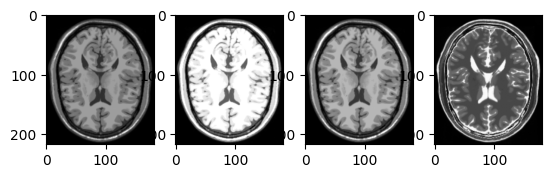

In [13]:
seed = (1, 2)
fig, axs = plt.subplots(1,4)

axs[0].imshow(t1_df['img_pxl'][0], cmap='grey')
axs[1].imshow(tf.image.adjust_brightness(t1_df['img_pxl'][0], delta=0.5), cmap='grey')
axs[2].imshow(tf.image.stateless_random_brightness(t1_df['img_pxl'][0], 0.2, seed), cmap='grey')
axs[3].imshow(t2_df['img_pxl'][0], cmap='grey')
plt.show();


Loss Functions

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss